
# Семинар 8 - Алгоритмы анализа стереопар изображений

***

Полезные материалы:

- [First Principles of Computer Vision - Camera Calibration | Uncalibrated Stereo](https://youtube.com/playlist?list=PL2zRqk16wsdoCCLpou-dGo7QQNks1Ppzo&si=iXEBEehuQr-IgIVC) - плейлист с серией лекций по калибровке камеры и стереозрению
- [Simple Stereo | Camera Calibration](https://youtu.be/hUVyDabn1Mg?si=HmalQZKI9ytoyxPn) - лекция из плейлиста выше, в которой доступно раскрывается тема данного семинара

На этом семинаре будет разобрана тема стереозрения, которая заключается в применении нескольких видов камер для получения информации о глубине обзора. Используя стереозрение, можно определить местоположение точки в мире по ее изображениям в разных ракурсах камеры.

Термин охватывает многие приложения, работающие с несколькими видами отслеживаемого объекта под разными углами. Это могут быть стереокамеры, которые имеют несколько камер на одних и тех же устройствах, или разные виды с разных устройств.

1. **3D реконструкция с нескольких ракурсов**: знаем параметры калибровки каждой из камер, необходимо найти положение 3D объекта в мировых координатах.

2. **Оценка на основе движения (Structure From Motion)**: не знаем параметры калибровки, необходимо одновременно восстановить и координаты, и калибровку.

Первая задача проще в своей постановке, рассмотрим ее.

## Моно/Стерео зрение

_Источник изображений: https://github.com/polygon-software/python-visual-odometry_

![1_projection_and_stereo](data/1_projection_and_stereo.png)

**Идея:** можем найти пересечение лучей, исходящих из разных камер, и по параметрам камеры определить расстояние до объекта. Вы можете ощутить эффект стереовидения на основе своих глаз. Поставьте палец перед глазами. Закройте один глаз, потом другой глаз. Вы заметите, что пальцы, кажется, прыгают слева направо. Это наблюдаемое горизонтальное смещение называется диспаратностью (расхождением, disparity).

![3_stereo_cases](data/3_stereo_cases.png)

Рассмотрим более простой случай с выровненными (ректифицированными) камерами.

![4_stereo_vision_simple](data/4_stereo_vision_simple.png)

## Вопрос 1 

Зная $f$ (фокальное расстояние камер), $b$ (расстояние между камерами), $u_l$, $u_r$, определить расстояние до объекта $Z_{p}$.

**Ответ:** $Z_p = ...$

## Расчет диспаратности с помощью OpenCV

In [1]:
!wget https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_l.png -O data/tsukuba_l.png
!wget https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_r.png -O data/tsukuba_r.png

--2024-05-20 19:53:05--  https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_l.png
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... соединение установлено.
HTTP-запрос отправлен. Ожидание ответа… 200 OK
Длина: 85192 (83K) [image/png]
Сохранение в: «data/tsukuba_l.png»

data/tsukuba_l.png  100%[===================>]  83,20K  --.-KB/s    за 0,03s   

2024-05-20 19:53:06 (2,47 MB/s) - «data/tsukuba_l.png» сохранён [85192/85192]

--2024-05-20 19:53:06--  https://raw.githubusercontent.com/jagracar/OpenCV-python-tests/master/OpenCV-tutorials/data/tsukuba_r.png
Распознаётся raw.githubusercontent.com (raw.githubusercontent.com)… 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Подключение к raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... соединение

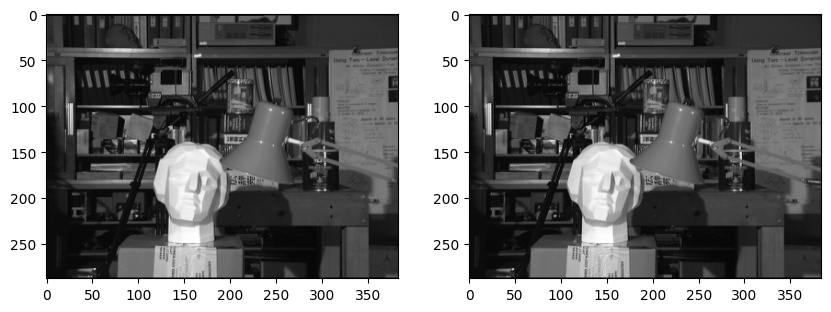

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

imgL = cv2.imread('data/tsukuba_l.png',0)
imgR = cv2.imread('data/tsukuba_r.png',0)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

ax[0].imshow(imgL, cmap="gray")
ax[1].imshow(imgR, cmap="gray")

### cv2.StereoBM_create

https://docs.opencv.org/4.5.0/d9/dba/classcv_1_1StereoBM.html#a04fdf00525f82fe708d556e2cd359004

Чем меньше `blockSize` - тем детальнее карта диспаратности, однако и количество шума растет.

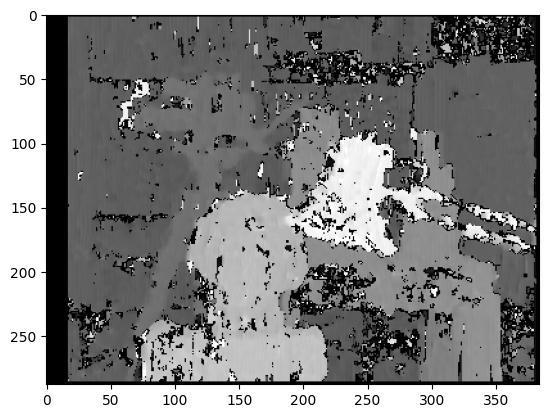

In [3]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=5,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

При слишком больших значениях `blockSize` шум отсутствует, однако детализация крайне низка:

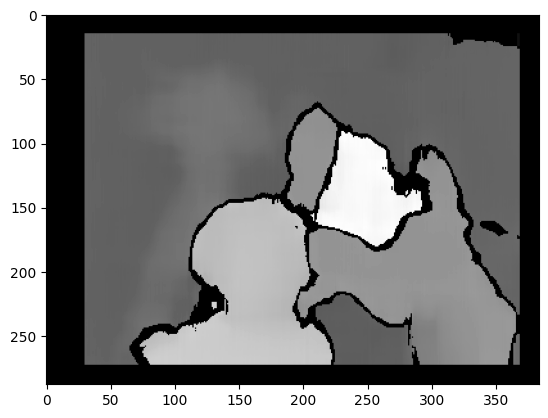

In [4]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=31,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

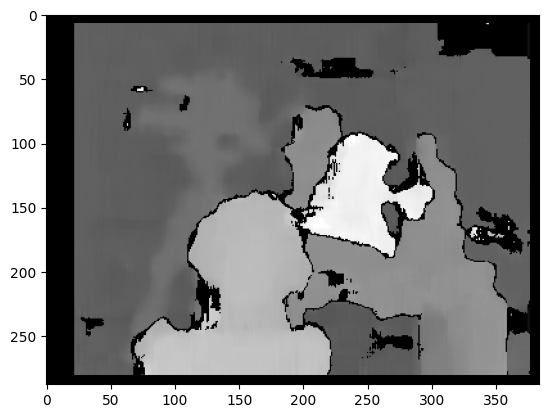

In [5]:
stereo = cv2.StereoBM_create(
    numDisparities=16,  # search range for each pixel
    blockSize=15,       # linear size of the blocks
)
disparity = stereo.compute(imgL, imgR)

plt.imshow(disparity, cmap='gray')

## Задание 1 - реализация алгоритма расчета диспаратности

Рассмотрим базовый жадный алгоритм наилучшего соответсвия (winner takes all, WTA) между изображениями с помощью блоков и метрики близости (sum of absolute difference, SAD).

![alg](data/alg.png)

**Заполните пропуски в коде**

In [16]:
def compare_blocks(block_left: np.array, block_right: np.array) -> float:
    '''
    Takes blocks from left/right image and returns the sum of absolute differences.
    '''
    absdiff = np.sum(np.abs(block_left - block_right))
    return absdiff

def get_disparity(imgL: np.array, imgR: np.array, numDisparities: int, blockSize: int) -> np.array:
    H, W = imgL.shape
    disparity_map = np.zeros_like(imgL)

    half_block_size = blockSize // 2

    for i in range(half_block_size, H - half_block_size):
        for j in range(half_block_size, W - half_block_size):

            # Extract the block from the left image
            block_left = imgL[
                i - half_block_size:i + half_block_size + 1,
                j - half_block_size:j + half_block_size + 1
            ]

            min_sad = np.inf
            min_k = 0

            for k in range(numDisparities):
                j_right = j - k
                if j_right - half_block_size >= 0:
                    block_right = imgR[
                        i - half_block_size:i + half_block_size + 1,
                        j_right - half_block_size:j_right + half_block_size + 1
                    ]

                    sad = compare_blocks(block_left, block_right)

                    if sad < min_sad:
                        min_sad = sad
                        min_k = k
            disparity_map[i, j] = min_k

    return disparity_map

## Вопрос 2

Заполняет ли алгоритм все пиксели глубины? Как можно улучшить его? (Например, рассмотрите вариант, когда `metrics.min()` выдает большое число, что делать в этом случае? Или предложите свою версию.)

**Ответ:**
Базовый алгоритм расчета диспаратности не всегда обеспечивает точные значения для всех пикселей глубины. Следующие проблемы могут встречаться:

- Проблемы вблизи краев объектов или в скрытых областях.
- Чувствительность к шуму 
- Потеря деталей

Для улучшения точности карты диспаратности можно применить следующие методы:

- Постобработка: Применение медианной фильтрации для удаления шума и сохранения краев.
- Использование других критериев, таких как нормализованная кросс-корреляция, для улучшения результатов в определенных условиях.

## Задание 2

Сравните свою реализацию с opencv StereoBM с помощью попиксельного сравнения карт диспаратности.

In [17]:
imgL = cv2.imread('data/tsukuba_l.png',0)
imgR = cv2.imread('data/tsukuba_r.png',0)

stereo = cv2.StereoBM_create(numDisparities=16, blockSize=15)
disparity_OpenCV = stereo.compute(imgL, imgR)
disparity_custom = get_disparity(imgL, imgR, numDisparities=16, blockSize=15)

disparity_OpenCV_norm = cv2.normalize(disparity_OpenCV, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)
disparity_custom_norm = cv2.normalize(disparity_custom, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX)

disparity_difference = np.abs(disparity_OpenCV_norm.astype(np.float32) - disparity_custom_norm.astype(np.float32))

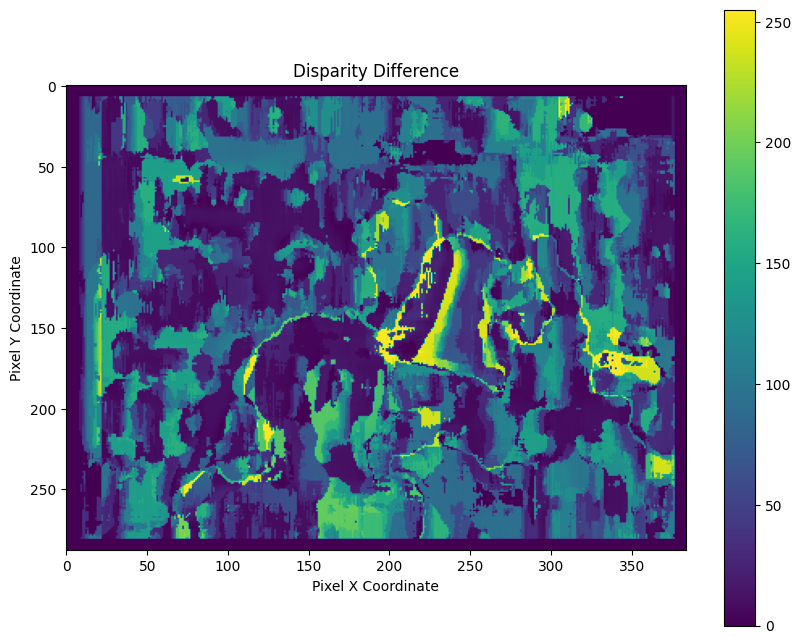

In [20]:
plt.figure(figsize=(10, 8))
plt.imshow(disparity_difference, cmap='viridis')
plt.colorbar()
plt.title('Methods difference')
plt.xlabel('Pixel X Coordinate')
plt.ylabel('Pixel Y Coordinate')
plt.show()


## Вопрос 3

Как еще с помощью пройденных классических алгоритмов можно построить карту диспаратности? Приведите краткое описание придуманного/существующего алгоритма.

**Ответ:**